In [1]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu' # device 배정
torch.manual_seed(42)
if device == 'cuda':
  torch.cuda.manual_seed_all(42)
device

'cuda'

In [8]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
# from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from matplotlib import rc
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
# from sklearn.model_selection import train_test_split
import torchvision.models as models
# import albumentations as A
# from albumentations.pytorch.transforms import ToTensorV2 # albumentations 텐서화 함수
from efficientnet_pytorch import EfficientNet
import numpy as np

# device = torch.device('mps:0' if torch.backends.mps.is_available() else 'cpu')
# rc('font', family='AppleGothic')
# plt.rcParams['axes.unicode_minus'] = False

## Random vs 김태희 vs 김혜수 (3진분류)

### 데이터 불러오기

In [10]:
train_transforms = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=20),
    # transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [27]:
valid_transforms = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 데이터셋 경로 설정
dataset_path = 'C://Users/user/Desktop/딥러닝/딥러닝/project'

# ImageFolder를 사용하여 전체 데이터셋을 불러옵니다.
train_dataset = ImageFolder(dataset_path + '/train', transform=train_transforms)
val_dataset = ImageFolder(dataset_path + '/val', transform=valid_transforms)
# test_dataset = ImageFolder(dataset_path + '/test', transform=test_transforms)

# DataLoader 설정
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
# test_loader = DataLoader(test_dataset, batch_size=batch_size)

### 데이터 확인

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

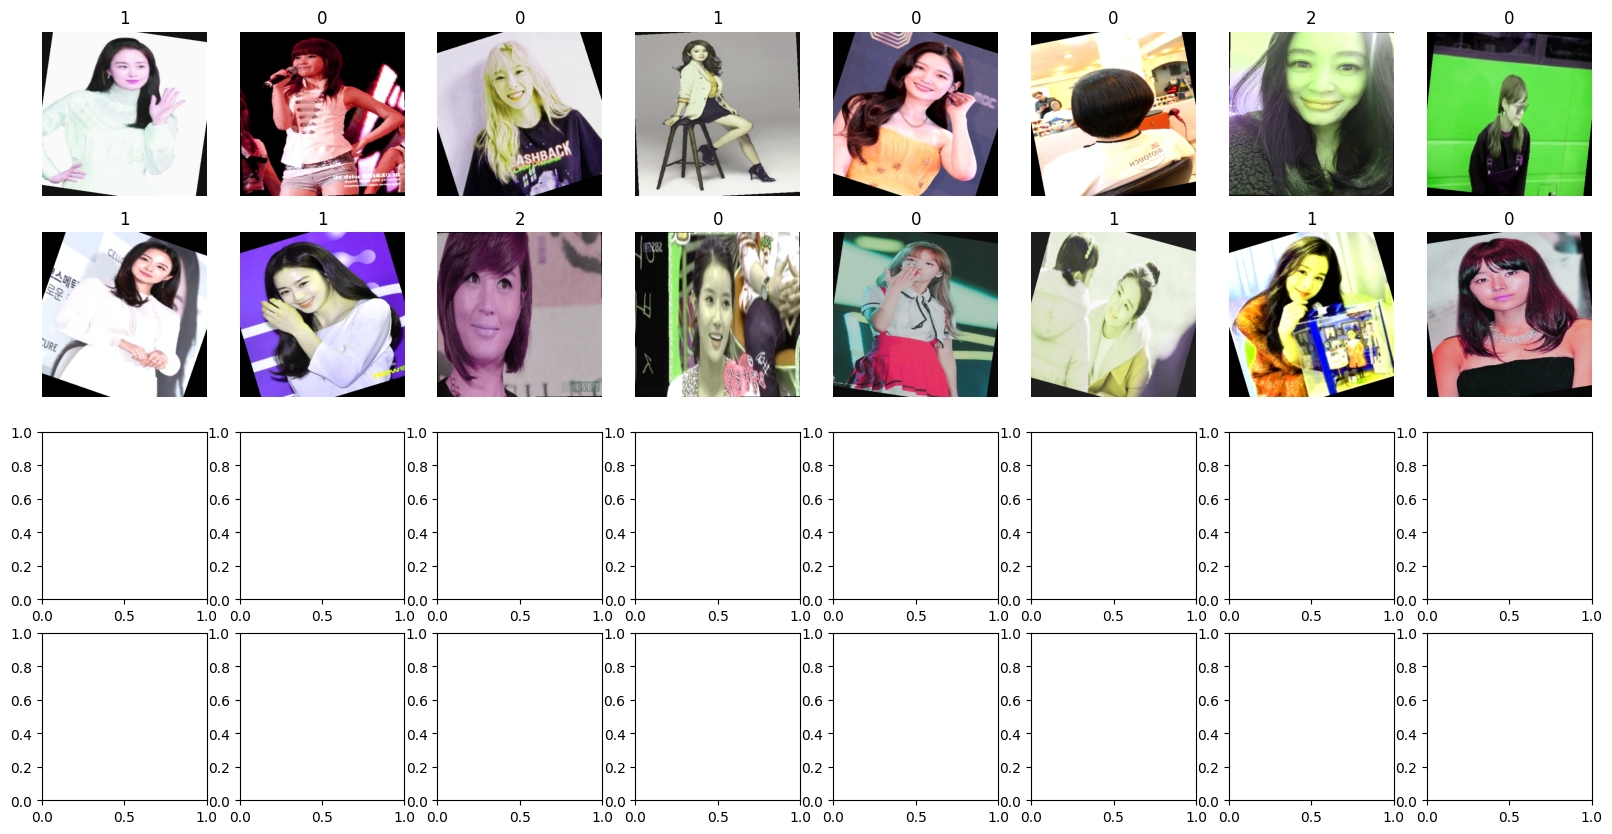

In [28]:
imgs, labels = next(iter(train_loader))

fig, axes = plt.subplots(4, 8, figsize=(20,10))

mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

for img, label, ax in zip(imgs, labels, axes.flatten()):
    ax.set_title(label.item())
    ax.imshow(img.permute(1,2,0).numpy() * std + mean)
    ax.axis('off')

In [1]:
# 0:random, 1:김태희, 2:김혜수

### 훈련 코드

In [32]:
model = EfficientNet.from_pretrained('efficientnet-b1', num_classes=3)
model = model.to(device)

# 손실 함수와 옵티마이저 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# 리스트 초기화
kk3_effb1_train_acc_lst = []
kk3_effb1_train_loss_lst = []
kk3_effb1_val_acc_lst = []
kk3_effb1_val_loss_lst = []

state = {}

# 모델 훈련
epochs = 50
for epoch in range(1, epochs+1):

    train_loss = 0
    total = 0
    correct = 0
    train_acc = 0

    model.train()

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # 정확도 계산
        _, predicted = torch.max(outputs, 1)  # 가장 높은 확률을 가진 클래스 선택
        total += labels.size(0)
        train_acc += (predicted == labels).sum().item()

    train_loss = round(train_loss / len(train_loader), 3)  # 미니배치 수로 나누어 평균을 계산
    train_acc = round((train_acc / total) * 100, 2)  # 백분율로 변환

    print(f'Trainset {epoch}/{epochs} Loss: {train_loss}, Accuracy: {train_acc}%')
    kk3_effb1_train_acc_lst.append(train_acc)
    kk3_effb1_train_loss_lst.append(train_loss)

    # 검증 데이터셋에 대한 손실과 정확도 계산
    val_loss = 0
    val_total = 0
    val_correct = 0
    val_acc = 0

    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            val_loss += criterion(outputs, labels).item()

            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_acc += (predicted == labels).sum().item()

    val_loss = round(val_loss / len(val_loader), 3)  # 검증 데이터셋의 손실 평균 계산
    val_acc = round((val_acc / val_total) * 100, 2)  # 검증 데이터셋의 정확도 계산

    print(f'Validation {epoch}/{epochs} Loss: {val_loss}, Accuracy: {val_acc}%')
    print()

    kk3_effb1_val_acc_lst.append(val_acc)
    kk3_effb1_val_loss_lst.append(val_loss)

    if np.max(kk3_effb1_val_acc_lst) <= val_acc:
        state['epoch'] = epoch
        state['net'] = model.state_dict()

        state['train_loss'] = train_loss
        state['val_loss'] = val_loss

        state['train_acc'] = train_acc
        state['val_acc'] = val_acc

# 모델 저장
torch.save(state, 'C://Users/user/Desktop/딥러닝/딥러닝/project/test_kk3_aug_448_efficientb1_{}_{}.pth'.format(str(state['epoch']), str(state['val_acc'])))

Loaded pretrained weights for efficientnet-b1
Trainset 1/50 Loss: 0.792, Accuracy: 65.45%
Validation 1/50 Loss: 0.529, Accuracy: 77.96%

Trainset 2/50 Loss: 0.438, Accuracy: 82.59%
Validation 2/50 Loss: 0.361, Accuracy: 86.66%

Trainset 3/50 Loss: 0.311, Accuracy: 88.42%
Validation 3/50 Loss: 0.314, Accuracy: 89.1%

Trainset 4/50 Loss: 0.225, Accuracy: 91.58%
Validation 4/50 Loss: 0.303, Accuracy: 89.1%

Trainset 5/50 Loss: 0.186, Accuracy: 93.43%
Validation 5/50 Loss: 0.266, Accuracy: 90.49%

Trainset 6/50 Loss: 0.152, Accuracy: 94.87%
Validation 6/50 Loss: 0.378, Accuracy: 86.89%

Trainset 7/50 Loss: 0.128, Accuracy: 95.46%
Validation 7/50 Loss: 0.268, Accuracy: 90.72%

Trainset 8/50 Loss: 0.11, Accuracy: 96.41%
Validation 8/50 Loss: 0.28, Accuracy: 91.07%

Trainset 9/50 Loss: 0.086, Accuracy: 96.91%
Validation 9/50 Loss: 0.378, Accuracy: 89.1%

Trainset 10/50 Loss: 0.075, Accuracy: 97.32%
Validation 10/50 Loss: 0.286, Accuracy: 90.49%

Trainset 11/50 Loss: 0.061, Accuracy: 98.35%
Va

### Acc and Loss 시각화

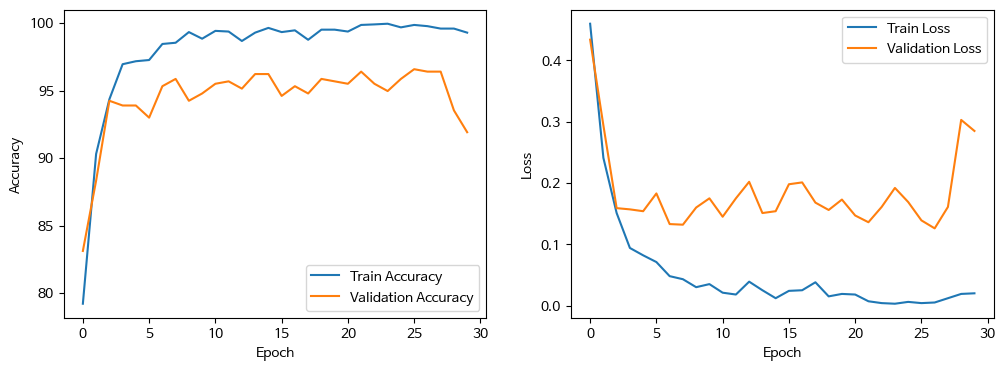

In [ ]:
# 정확도 및 손실을 그래프로 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(so_effb1_train_acc_lst, label='Train Accuracy')
plt.plot(so_effb1_val_acc_lst, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(so_effb1_train_loss_lst, label='Train Loss')
plt.plot(so_effb1_val_loss_lst, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

### 실제 이미지 test

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


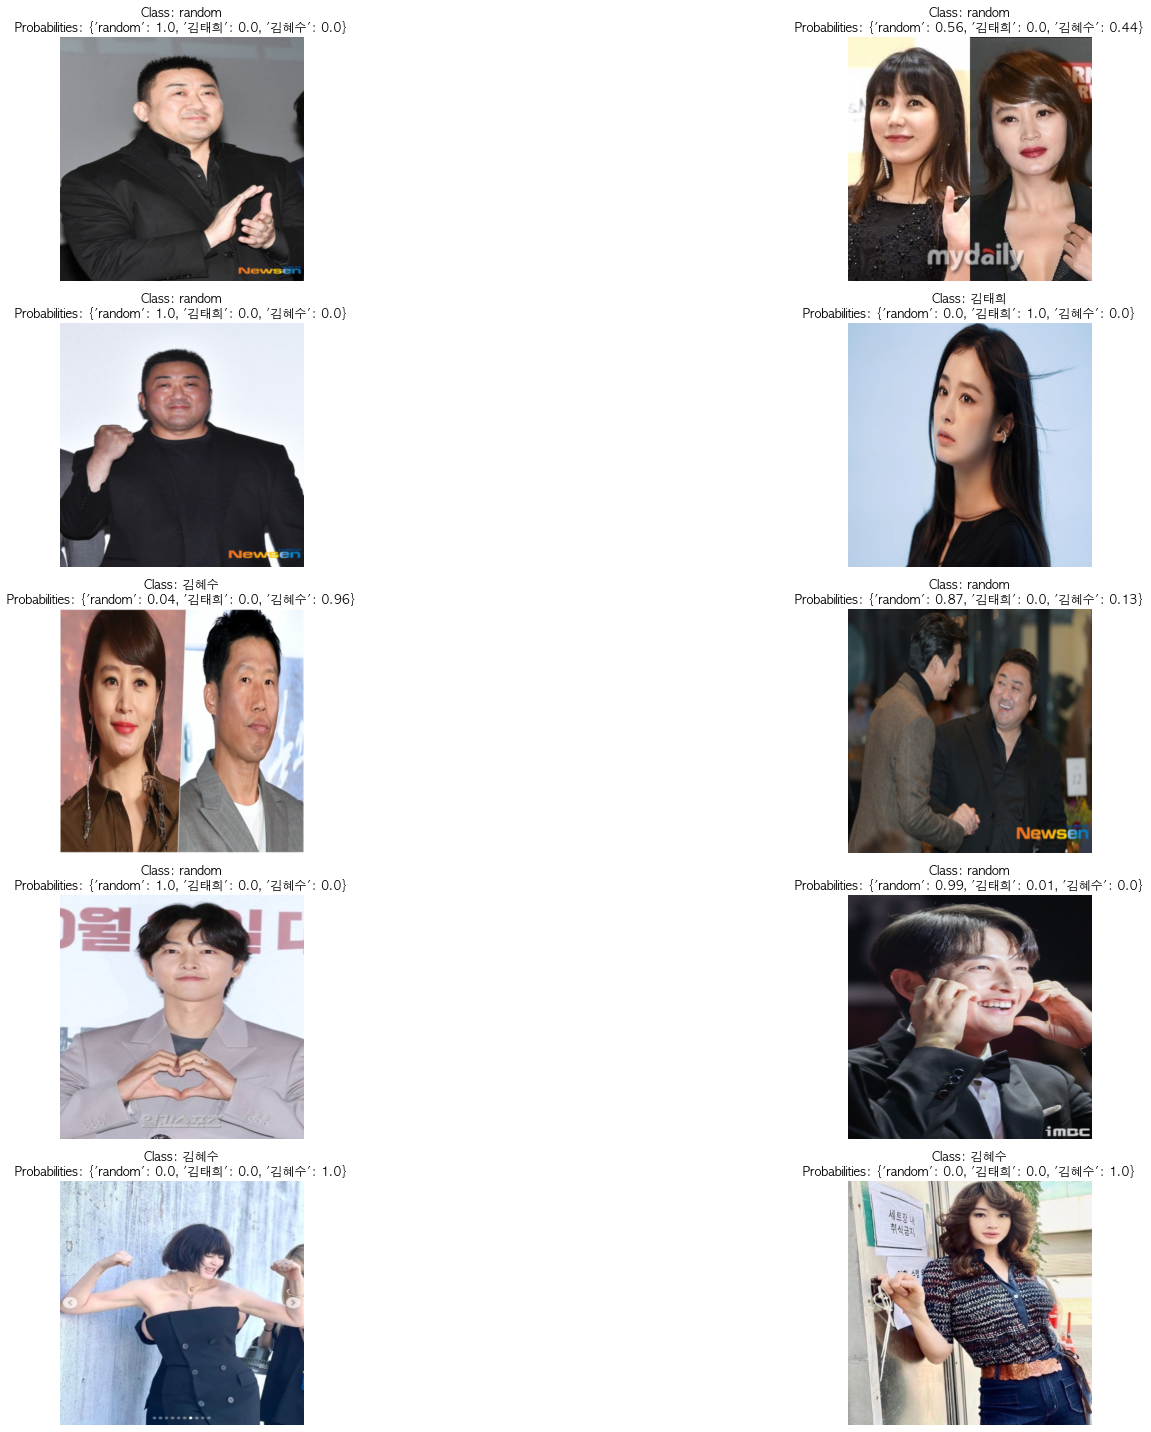

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


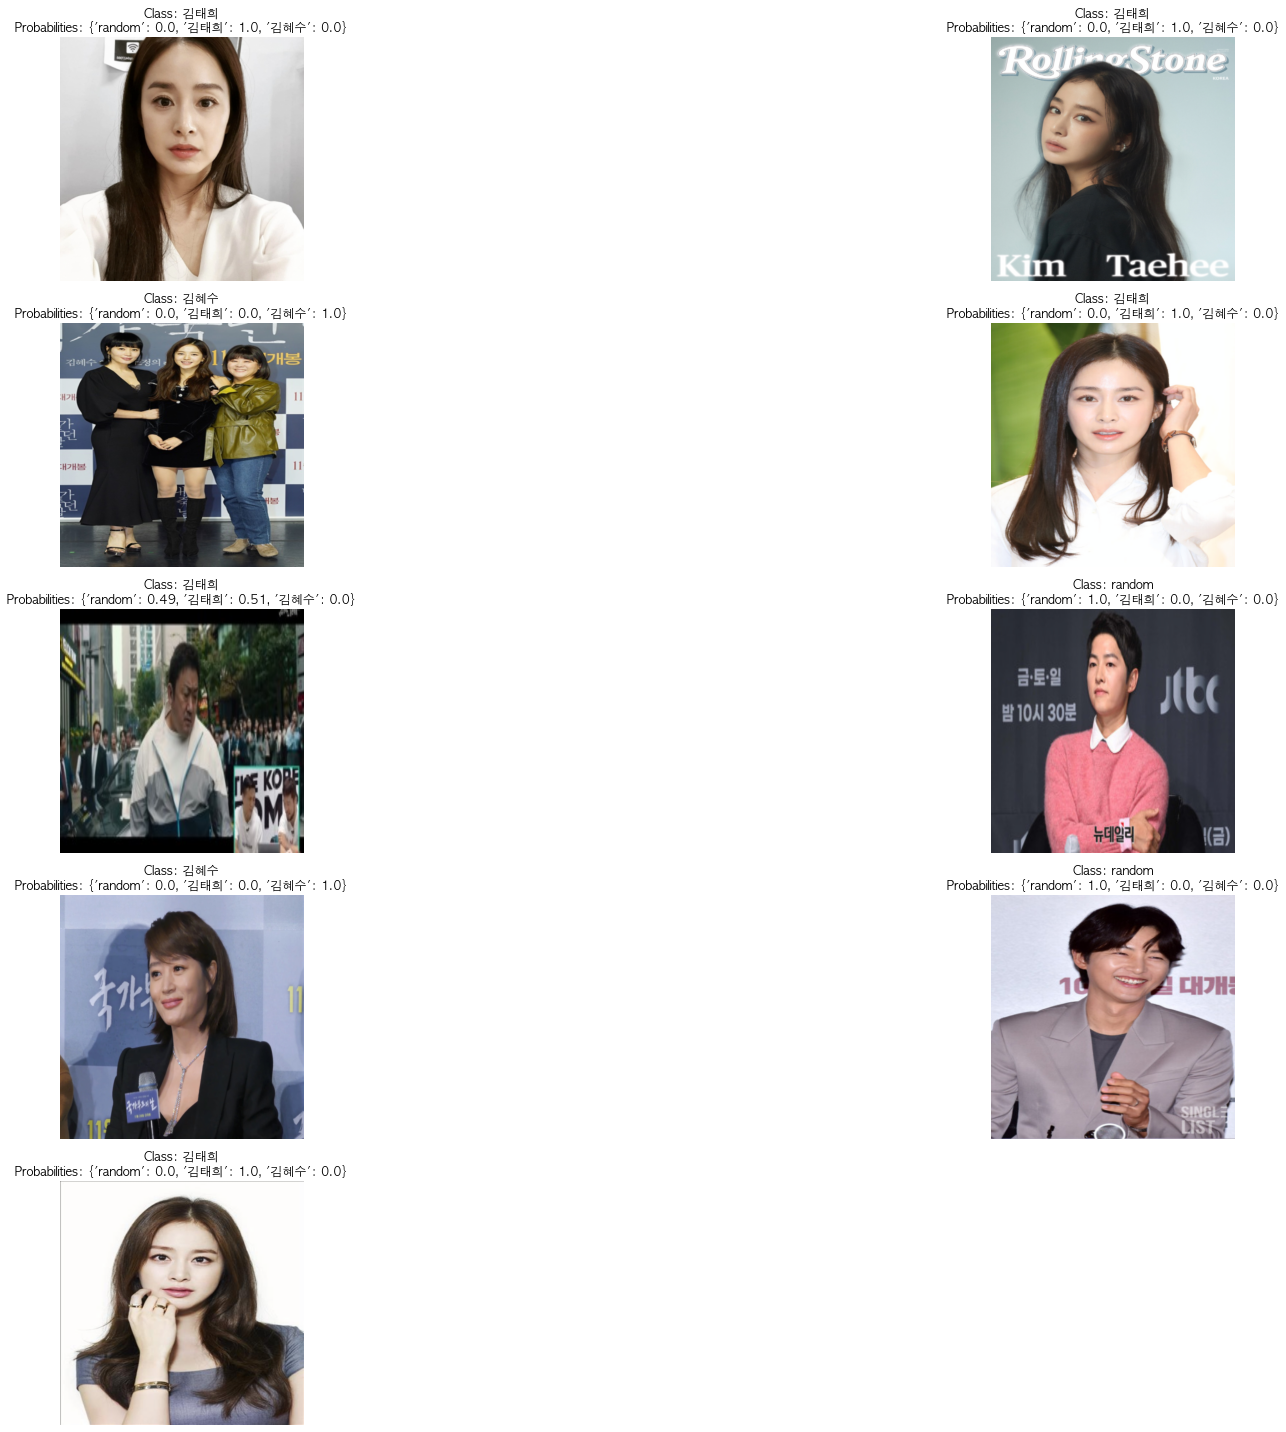

In [80]:
import os
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

# 모델 불러오기
model_path = '/Users/taeyoung/Desktop/딥러닝/new_class3_so_aug_448_efficientb1_14_92.29.pth'

# 모델 정의 (모델 아키텍처와 동일하게 정의해야 함)
model = EfficientNet.from_name('efficientnet-b1', num_classes=3)
model.to(device)

# 저장된 모델 가중치 불러오기
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint['net'])
model.eval()

# 폴더 경로 설정
image_folder = '/Users/taeyoung/Desktop/딥러닝/test'  # 이미지 파일들이 있는 폴더 경로

# 폴더 내의 모든 이미지 파일 리스트
image_files = [os.path.join(image_folder, file) for file in os.listdir(image_folder) if file.endswith(('.jpg', '.jpeg', '.png'))]

# 데이터 전처리 변환
transform = transforms.Compose([
    transforms.Resize((448, 448)),  # 모델에 맞는 이미지 크기로 조정
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class_names = ["random", "김태희", '김혜수']

# 결과를 저장할 리스트 초기화
results = []

# 이미지 파일들에 대한 예측
for image_path in image_files:
    with torch.no_grad():
        image = Image.open(image_path).convert("RGB")
        image = transform(image).unsqueeze(0).to(device)

        output = model(image)
        probabilities = torch.softmax(output, dim=1)[0].cpu().numpy()
        predicted_class = np.argmax(probabilities)
        predicted_class_name = class_names[predicted_class]  # 예측 클래스 이름
        predicted_class_probs = dict(zip(class_names, probabilities))  # 클래스 이름과 확률을 딕셔너리로 저장

        # 확률을 소수점 둘째 자리까지 반올림하여 표시
        predicted_class_probs = {k: round(v, 2) for k, v in predicted_class_probs.items()}

        results.append({
            'image_path': image_path,
            'predicted_class': predicted_class_name,
            'predicted_class_probs': predicted_class_probs
        })

# 시각화
images_per_page = 10
for i in range(0, len(results), images_per_page):
    plt.figure(figsize=(30, 20))
    for j, result in enumerate(results[i:i + images_per_page]):
        plt.subplot(5, 2, j + 1)
        image = Image.open(result['image_path'])
        plt.imshow(transform(image).permute(1, 2, 0).numpy() * std + mean)
        plt.title(f"Class: {result['predicted_class']}\nProbabilities: {result['predicted_class_probs']}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()